In [ ]:
# -*- coding: utf-8 -*-

import tensorflow as tf
import scipy.sparse as sp
import numpy as np

def normalized_adj(adj):
    # Convert the adjacency matrix to a TensorFlow tensor
    adj = tf.convert_to_tensor(adj, dtype=tf.float32)

    # Calculate the row sum
    rowsum = tf.reduce_sum(adj, axis=1)

    # Calculate the inverse square root of the row sums
    d_inv_sqrt = 1.0 / tf.sqrt(tf.maximum(rowsum, 1e-12))  # Add a small constant to avoid division by zero

    # Create a diagonal matrix of the inverse square root
    d_mat_inv_sqrt = tf.linalg.diag(d_inv_sqrt)

    # Calculate the normalized adjacency matrix
    normalized_adj = tf.matmul(tf.matmul(d_mat_inv_sqrt,adj), d_mat_inv_sqrt)

    return normalized_adj

def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)
def sparse_to_tuple(mx):
    mx = mx.tocoo()
    coords = np.vstack((mx.row, mx.col)).transpose()
    L = tf.SparseTensor(coords, mx.data, mx.shape)
    return tf.sparse.reorder(L)

def calculate_laplacian(adj, lambda_max=1):
    adj = normalized_adj(adj + tf.eye(adj.shape[0], dtype=tf.float32))
    return adj

def weight_variable_glorot(input_dim, output_dim, name=""):
    init_range = np.sqrt(6.0 / (input_dim + output_dim))
    initial = tf.compat.v1.random_uniform([input_dim, output_dim], minval=-init_range,
                            maxval=init_range, dtype=tf.float32)

    return tf.Variable(initial,name=name)


In [ ]:
# import numpy as np
# import pandas as pd
# import pickle as pkl

# def preprocess_data(data, time_len, rate, seq_len, pre_len):
#     train_size = int(time_len * rate)
#     train_data = data[0:train_size]
#     test_data = data[train_size:time_len]
#     # Mask = np.random.choice([0,1], size=(speed_matrix.shape), p = [1 - mask_ones_proportion, mask_ones_proportion])
#     # masked_speed_matrix = np.multiply(speed_matrix, Mask)
#     # Mask[np.where(masked_speed_matrix == 0)] = 0
#     # mask_zero_values = np.where(Mask == 0)[0].shape[0] / (Mask.shape[0] * Mask.shape[1])
#     # print('\t Masked dataset missing rate:', np.around(mask_zero_values, decimals=4),'(mask zero rate:', np.around(1 - mask_ones_proportion, decimals=4), ')')


#     trainX, trainY, testX, testY = [], [], [], []
#     for i in range(len(train_data) - seq_len - pre_len):
#         a = train_data[i: i + seq_len + pre_len]
#         trainX.append(a[0 : seq_len])
#         trainY.append(a[seq_len : seq_len + pre_len])
#     for i in range(len(test_data) - seq_len -pre_len):
#         b = test_data[i: i + seq_len + pre_len]
#         testX.append(b[0 : seq_len])
#         testY.append(b[seq_len : seq_len + pre_len])

#     trainX1 = np.array(trainX)
#     trainY1 = np.array(trainY)
#     testX1 = np.array(testX)
#     testY1 = np.array(testY)
#     return trainX1, trainY1, testX1, testY1

In [ ]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 27 09:39:22 2018

@author: lhfcitylab
"""

import matplotlib.pyplot as plt

def plot_result(test_result,test_label1):
    ##all test result visualization
    fig1 = plt.figure(figsize=(11,2))
    a_pred = test_result
    print(a_pred.shape)
    a_true = test_label1
    print(a_pred.shape)
    plt.plot(a_pred,'c-',label='Our Model')
    plt.plot(a_true,color = '0.5',label='Ground Truth')
    plt.legend(loc='best',fontsize=10)
    labels = ["06/19/2012","06/20/2012","06/21/2012","06/24/2012","06/25/2012","06/26/2012","06/27/2012","06/28/2012"]
    plt.xlabel("Time(MM/DD/YYYY)")
    plt.ylabel("Traffic speed")
    plt.xticks([0,320,640,960,1280,1600,1920,2240],labels)
    fig1 = plt.figure(figsize=(7,1.5))
    a_pred = test_result[0:96]
    a_true = test_label1[0:96]
    labels  = ["00.00", "03.00", "06.00", "09.00", "12.00","15.00","18.00","21.00","24.00"]
    plt.xticks([0,12,24,36,48,60,72,84,96],labels)
    plt.ylabel("Traffic speed")
    plt.xlabel("Time(hour)")
    plt.plot(a_pred,'c-',label="Our Model")
    plt.plot(a_true,color = '0.5',label="Ground Truth")
    plt.legend(loc='best',fontsize=10)


In [ ]:
import torch
from torch.autograd import Variable
import torch.utils.data as utils
import math
import numpy as np
import copy
import time

def PrepareDataset(speed_matrix, \
                   seq_len, \
                   pred_len , \
                   train_propotion, \
                   mask_ones_proportion , \
                   masking , \
                   masking_type = 'random', \
                   delta_last_obsv = False, \
                   shuffle = False, \
                   random_seed = 1024, \
                   ):
    """ Prepare training and testing datasets and dataloaders.

    Convert speed/volume/occupancy matrix to training and testing dataset.
    The vertical axis of speed_matrix is the time axis and the horizontal axis
    is the spatial axis.

    Args:
        speed_matrix: a Matrix containing spatial-temporal speed data for a network
        seq_len: length of input sequence
        pred_len: length of predicted sequence
    Returns:
        Training dataloader
        Testing dataloader
    """

    print('Start Generate Data')
    print('\t input_len:', seq_len, '\t\t\t pred_len:', pred_len)
    print('\t train_set:', train_propotion, '\t\t test_set:', np.around(1 - train_propotion, decimals=2))
    print('\t masking:', masking, '\t\t\t mask_ones_rate:', mask_ones_proportion, '\t\t delta & last_obsv:', delta_last_obsv)
    # print('\t shuffle dataset:', shuffle, '\t\t random_seed:', random_seed)

    # np.random.seed(random_seed)

    time_len = speed_matrix.shape[0]
    speed_matrix = speed_matrix.clip(0, 100)

    max_speed = speed_matrix.max().max()
    speed_matrix =  speed_matrix / max_speed

    data_zero_values = np.where(speed_matrix == 0)[0].shape[0]
    data_zero_rate = data_zero_values / (speed_matrix.shape[0] * speed_matrix.shape[1])
    print('Orignal dataset missing rate:', data_zero_rate)

    print('Generating input and labels...')
    if not masking:
        speed_sequences, speed_labels = [], []
        for i in range(time_len - seq_len - pred_len):
            speed_sequences.append(speed_matrix[i:i+seq_len])
            speed_labels.append(speed_matrix[i+seq_len:i+seq_len+pred_len])
        speed_sequences, speed_labels = np.asarray(speed_sequences), np.asarray(speed_labels)
        print('Input sequences and labels are generated.')

    else:
        # using zero-one mask to randomly set elements to zeros
        # genertate mask

        if masking_type == 'random':
            Mask = np.random.choice([0,1], size=(speed_matrix.shape), p = [1 - mask_ones_proportion, mask_ones_proportion])
            masked_speed_matrix = np.multiply(speed_matrix, Mask)
            Mask[np.where(masked_speed_matrix == 0)] = 0
            mask_zero_values = np.where(Mask == 0)[0].shape[0] / (Mask.shape[0] * Mask.shape[1])
            print('\t Masked dataset missing rate:', np.around(mask_zero_values, decimals=4),'(mask zero rate:', np.around(1 - mask_ones_proportion, decimals=4), ')')

        speed_sequences, speed_labels = [], []
        for i in range(time_len - seq_len - pred_len):
            speed_sequences.append(masked_speed_matrix[i:i+seq_len])
            speed_labels.append(speed_matrix[i+seq_len:i+seq_len+pred_len])
        speed_sequences, speed_labels = np.asarray(speed_sequences), np.asarray(speed_labels)
        print('Input sequences, labels, and masks are generated.')

        # Mask sequences
        Mask = np.ones_like(speed_sequences)
        Mask[np.where(speed_sequences == 0)] = 0

        if delta_last_obsv:
            # temporal information
            interval = 5 # 5 minutes
            S = np.zeros_like(speed_sequences) # time stamps
            for i in range(S.shape[1]):
                S[:,i,:] = interval * i

            Delta = np.zeros_like(speed_sequences) # time intervals
            for i in range(1, S.shape[1]):
                Delta[:,i,:] = S[:,i,:] - S[:,i-1,:]

            Delta = Delta / Delta.max() # normalize

            missing_index = np.where(speed_sequences == 0)

            X_last_obsv = np.copy(speed_sequences)
            for idx in range(missing_index[0].shape[0]):
                i = missing_index[0][idx]
                j = missing_index[1][idx]
                k = missing_index[2][idx]
                if j != 0 and j != seq_len-1:
                    Delta[i,j+1,k] = Delta[i,j+1,k] + Delta[i,j,k]
                if j != 0:
                    X_last_obsv[i,j,k] = X_last_obsv[i,j-1,k] # last observation

            print('Time intervals of missing values and last_observations are generated.')

    # shuffle and split the dataset to training and testing datasets
    print('Start to shuffle dataset ...')
    sample_size = speed_sequences.shape[0]
    if shuffle:
        sample_size = speed_sequences.shape[0]
        index = np.arange(sample_size, dtype = int)
        np.random.shuffle(index)
        speed_sequences = speed_sequences[index]
        speed_labels = speed_labels[index]
        if masking:
            Mask = Mask[index]
            if delta_last_obsv:
                Delta = Delta[index]
                X_last_obsv = X_last_obsv[index]
    print('Dataset Shuffled. Start to split dataset ...')

    if not masking:
        dataset_agger = speed_sequences
    else:
        dataset_agger = speed_sequences
        # speed_sequences = np.expand_dims(speed_sequences, axis=1)
        # Mask = np.expand_dims(Mask, axis=1)
        # if delta_last_obsv:
        #     Delta = np.expand_dims(Delta, axis=1)
        #     X_last_obsv = np.expand_dims(X_last_obsv, axis=1)
        #     dataset_agger = np.concatenate((speed_sequences, Mask, Delta, X_last_obsv), axis = 1)
        # else:
        #     dataset_agger = np.concatenate((speed_sequences, Mask), axis = 1)

    train_index = int(np.floor(sample_size * train_propotion))
    # valid_index = int(np.floor(sample_size * ( train_propotion + valid_propotion)))

    if masking:
        train_data, train_label = dataset_agger[:train_index], speed_labels[:train_index]
        # valid_data, valid_label = dataset_agger[train_index:valid_index], speed_labels[train_index:valid_index]
        test_data, test_label = dataset_agger[train_index:], speed_labels[train_index:]
    else:
        train_data, train_label = speed_sequences[:train_index], speed_labels[:train_index]
        # valid_data, valid_label = speed_sequences[train_index:valid_index], speed_labels[train_index:valid_index]
        test_data, test_label = speed_sequences[train_index:], speed_labels[train_index:]

    train_data, train_label = np.array(train_data), np.array(train_label)
    # valid_data, valid_label = torch.Tensor(valid_data), torch.Tensor(valid_label)
    test_data, test_label = np.array(test_data), np.array(test_label)

    print('Finished')

    return train_data,  train_label, test_data, test_label





In [ ]:
def dynamic_adjacency(X,adj,node):
  input_len = X.shape[1]
  # X = tf.matmul(X,adj)
  x1 = X[:,0,:]
  x1 = tf.reshape(x1, shape=[-1,node])
  x1 = tf.transpose(x1, perm=[1,0])
  x2 = X[:,1,:]
  x2 = tf.reshape(x2, shape=[-1,node])
  trans_prob = tf.matmul(x1,x2)
  sum_prob = tf.reduce_sum(trans_prob, axis=1)
  tiled_sum_prob = tf.tile(tf.expand_dims(sum_prob, axis=1), [1, node])
  transitional_probability = tf.math.divide_no_nan(trans_prob, tiled_sum_prob)
  remain_input_len = input_len-2
  if input_len>2:
      for i in range(remain_input_len):
         x3 = X[:,i+2,:]
         x3 = tf.reshape(x3, shape=[-1,node])
         x3 = tf.transpose(x3, perm=[1,0])
         trans_prob = tf.matmul(x3,x2)
         trans_prob = tf.matmul(transitional_probability,trans_prob)
         sum_prob = tf.reduce_sum(trans_prob, axis=1)
         tiled_sum_prob = tf.tile(tf.expand_dims(sum_prob, axis=1), [1, node])
         transitional_probability = tf.math.divide_no_nan(trans_prob, tiled_sum_prob)
         x3 = tf.transpose(x3, perm=[1,0])
         x2 = x3
  return transitional_probability

In [ ]:
import tensorflow as tf
from tensorflow.compat.v1.nn.rnn_cell import RNNCell

class pstgCell(RNNCell):

    def call(self, inputs, **kwargs):
        pass

    def __init__(self, num_units,adj, node_embed,num_nodes, input_size=None,
                 act=tf.nn.tanh, reuse=None):

        super(pstgCell, self).__init__(_reuse=reuse)
        self._act = act
        self._nodes = num_nodes
        self._units = num_units
        self._adj = (calculate_laplacian(adj))
        self.node_embed = node_embed


    @property
    def state_size(self):
        return self._nodes * self._units

    @property
    def output_size(self):
        return self._units

    def __call__(self, inputs,state, scope=None):


        with tf.compat.v1.variable_scope(scope or "tgcn"):
            with tf.compat.v1.variable_scope("gates"):
                value = tf.nn.sigmoid(self._gc(inputs, state, 2 * self._units, bias=1.0, scope=scope))
                r, u = tf.split(value=value, num_or_size_splits=2, axis=1)

            with tf.compat.v1.variable_scope("candidate"):
                r_state = r * state
                c = self._act(self._gc(inputs, r_state, self._units, scope=scope))
            new_h = u * state + (1 - u) * c
        return new_h, new_h


    def _gc(self, inputs, state, output_size, bias=0.0, scope=None):
        emd_dim = 32
        inputs = tf.expand_dims(inputs, 2)
        state = tf.reshape(state, (-1, self._nodes, self._units))
        x_s = tf.concat([inputs, state], axis=2)
        input_size = x_s.get_shape()[2]
        weights_pool = tf.Variable(tf.random.normal([ emd_dim , input_size, output_size]), trainable=True)
        bias_pool = tf.Variable(tf.random.normal([ emd_dim , output_size]), trainable=True)
        weight = tf.einsum('nd,dio->nio',  self.node_embed, weights_pool)
        bias = tf.matmul( self.node_embed, bias_pool)
        x0 = tf.transpose(x_s, perm=[1, 2, 0])
        x0 = tf.reshape(x0, shape=[self._nodes, -1])

        scope = tf.compat.v1.get_variable_scope()
        with tf.compat.v1.variable_scope(scope):
            # for m in self._adj:
            x1 = tf.matmul(self._adj, x0)
            # print("xx1",x1.shape)
            x = tf.reshape(x1, shape=[self._nodes, input_size,-1])
            x = tf.transpose(x,perm=[2,0,1])
            x = tf.einsum('bni,nio->bno', x, weight)+bias
            x = tf.reshape(x, shape=[-1, self._nodes, output_size])
            x = tf.reshape(x, shape=[-1, self._nodes * output_size])
        return x

data (12671, 228)
Start Generate Data
	 input_len: 10 			 pred_len: 1
	 train_set: 0.8 		 test_set: 0.2
	 masking: True 			 mask_ones_rate: 0.8 		 delta & last_obsv: False
Orignal dataset missing rate: 0.0
Generating input and labels...
	 Masked dataset missing rate: 0.1995 (mask zero rate: 0.2 )
Input sequences, labels, and masks are generated.
Start to shuffle dataset ...
Dataset Shuffled. Start to split dataset ...
Finished
(10128, 10, 228)
(10128, 1, 228)
Tensor("div_no_nan_8:0", shape=(228, 228), dtype=float32)


Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API


Iter:0 train_rmse:289.2 test_loss:3.612e+06 test_rmse:3.536 test_acc:-3.886
Iter:1 train_rmse:158.8 test_loss:1.056e+06 test_rmse:1.91 test_acc:-1.639
Iter:2 train_rmse:84.68 test_loss:2.889e+05 test_rmse:0.9955 test_acc:-0.3757
Iter:3 train_rmse:59.54 test_loss:1.351e+05 test_rmse:0.6771 test_acc:0.06427
Iter:4 train_rmse:54.97 test_loss:1.13e+05 test_rmse:0.6179 test_acc:0.1461
Iter:5 train_rmse:53.14 test_loss:1.056e+05 test_rmse:0.5969 test_acc:0.1751
Iter:6 train_rmse:53.2 test_loss:1.055e+05 test_rmse:0.5967 test_acc:0.1754
Iter:7 train_rmse:52.63 test_loss:1.046e+05 test_rmse:0.5941 test_acc:0.179
Iter:8 train_rmse:52.45 test_loss:1.018e+05 test_rmse:0.5858 test_acc:0.1904
Iter:9 train_rmse:52.32 test_loss:1.014e+05 test_rmse:0.5848 test_acc:0.1919
Iter:10 train_rmse:52.06 test_loss:1.005e+05 test_rmse:0.5818 test_acc:0.1959
Iter:11 train_rmse:51.9 test_loss:9.987e+04 test_rmse:0.5801 test_acc:0.1984
Iter:12 train_rmse:51.74 test_loss:9.926e+04 test_rmse:0.5782 test_acc:0.2009
I

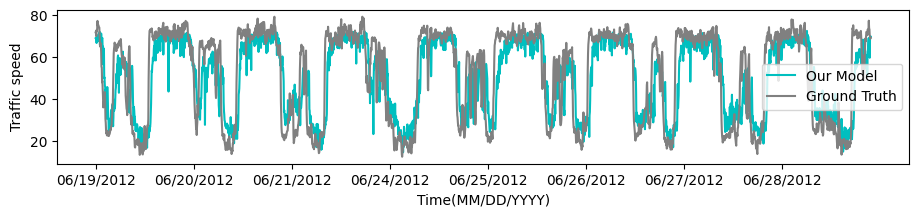

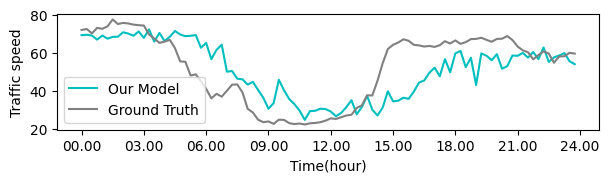

In [ ]:
import pickle as pkl
import tensorflow as tf
import pandas as pd
import numpy as np
import math
import os
import numpy.linalg as la
tf.compat.v1.reset_default_graph()
from sklearn.metrics import mean_squared_error,mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time

time_start = time.time()

train_rate =  0.8
seq_len = 10
output_dim = pre_len =1
lr = 0.001
training_epoch =500
batch_size = 32
gru_units = 64

mask_ones_proportion = .8
masking = True
noise_name = 'None'
PG = 4
PeMS_adj = pd.read_csv('https://raw.githubusercontent.com/AmitRoy7781/USTGCN/master/PeMSD7/PeMSD7_adj.csv',header=None)
adj = np.mat(PeMS_adj)
data = pd.read_csv('https://raw.githubusercontent.com/AmitRoy7781/USTGCN/master/PeMSD7/PeMSD7_speed.csv')
# sz_adj = pd.read_csv('https://raw.githubusercontent.com/lehaifeng/T-GCN/master/data/sz_adj.csv',header=None)
# adj= np.mat(sz_adj)
# data = pd.read_csv('https://raw.githubusercontent.com/lehaifeng/T-GCN/master/data/sz_speed.csv')
data1 =np.mat(data,dtype=np.float32)
print("data",data1.shape)
def MaxMinNormalization(x,Max,Min):
    x = (x-Min)/(Max-Min)
    return x

if noise_name == 'Gauss':
    print(noise_name)
    print("PG",PG)
    Gauss = np.random.normal(0,PG,size=data1.shape)
    noise_Gauss = MaxMinNormalization(Gauss,np.max(Gauss),np.min(Gauss))
    # print(noise_Gauss)
    data1 = data1 + noise_Gauss
    # print(data)
elif noise_name == 'Possion':
    print(noise_name)
    print("PG",PG)
    Possion = np.random.poisson(PG,size=data1.shape)
    noise_Possion = MaxMinNormalization(Possion,np.max(Possion),np.min(Possion))
    data1 = data1 + noise_Possion
else:
    data1 = data1
time_len = data1.shape[0]
num_nodes = data1.shape[1]
emd_dim = 32

#### normalization
max_value = np.max(data1)
data1  = data1/max_value
# trainX, trainY, testX, testY = preprocess_data(data1, time_len, train_rate, seq_len, pre_len)
trainX, trainY, testX, testY = PrepareDataset(data1, seq_len, pre_len,train_rate,  mask_ones_proportion ,masking)
print(trainX.shape)
print(trainY.shape)
# print(testX.shape)
# print(testY.shape)
totalbatch = int(trainX.shape[0]/batch_size)
training_data_count = len(trainX)

def PSTG(_X, weights, biases):
    node_embeddings = tf.Variable(tf.random.normal((num_nodes, emd_dim)), trainable=True)
    weight = tf.einsum('nd,dio->nio',  node_embeddings, weights)
    bias = tf.matmul(node_embeddings, biases)
    Ad_adjt = dynamic_adjacency(_X,adj,num_nodes)
    print(Ad_adjt)
    cell_1 = pstgCell(gru_units,Ad_adjt, node_embeddings,num_nodes=num_nodes)
    cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell([cell_1], state_is_tuple=True)
    _X = tf.unstack(_X, axis=1)
    outputs, states = tf.compat.v1.nn.static_rnn(cell, _X, dtype=tf.float32)
    out = tf.concat(outputs, axis=0)
    out = tf.reshape(out, shape=[seq_len,-1,num_nodes,gru_units])
    out = tf.transpose(out, perm=[1,0,2,3])
    last_output,alpha = self_attention1(out, weight_att, bias_att)
    output = tf.einsum('bni,nio->bno', last_output, weight)+bias
    output = tf.reshape(output,shape=[-1,num_nodes,pre_len])
    output = tf.transpose(output, perm=[0,2,1])
    output = tf.reshape(output, shape=[-1,num_nodes])

    return output, outputs, states, alpha,Ad_adjt

def self_attention1(x, weight_att,bias_att):
    x = tf.matmul(tf.reshape(x,[-1,gru_units]),weight_att['w1']) + bias_att['b1']
    f = tf.matmul(tf.reshape(x, [-1, num_nodes]), weight_att['w2']) + bias_att['b2']
    g = tf.matmul(tf.reshape(x, [-1, num_nodes]), weight_att['w2']) + bias_att['b2']
    h = tf.matmul(tf.reshape(x, [-1, num_nodes]), weight_att['w2']) + bias_att['b2']

    f1 = tf.reshape(f, [-1,seq_len])
    g1 = tf.reshape(g, [-1,seq_len])
    h1 = tf.reshape(h, [-1,seq_len])
    s = g1 * f1

    beta = tf.nn.softmax(s, axis=-1)  # attention map
    context = tf.expand_dims(beta,2) * tf.reshape(x,[-1,seq_len,num_nodes])

    context = tf.transpose(context,perm=[0,2,1])
    return context, beta
###### placeholders ######
tf.compat.v1.disable_eager_execution()
inputs = tf.compat.v1.placeholder(tf.float32, shape=[None, seq_len, num_nodes])
labels = tf.compat.v1.placeholder(tf.float32, shape=[None, pre_len, num_nodes])

# weights
weights_pool = tf.Variable(tf.random.normal([ emd_dim , seq_len, pre_len]), trainable=True)
bias_pool = tf.Variable(tf.random.normal([ emd_dim , pre_len]), trainable=True)
weight_att={
    'w1':tf.Variable(tf.compat.v1.random_normal([gru_units,1], stddev=0.1),name='att_w1'),
    'w2':tf.Variable(tf.compat.v1.random_normal([num_nodes,1], stddev=0.1),name='att_w2')}
bias_att = {
    'b1': tf.Variable(tf.compat.v1.random_normal([1]),name='att_b1'),
    'b2': tf.Variable(tf.compat.v1.random_normal([1]),name='att_b2')}

pred,ttto,ttts,alpha,ad_adj = PSTG(inputs, weights_pool, bias_pool)

y_pred = pred



###### optimizer ######
lambda_loss = 0.0015
Lreg = lambda_loss * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.compat.v1.trainable_variables())
label = tf.reshape(labels, [-1,num_nodes])
##loss
loss = tf.reduce_mean(tf.nn.l2_loss(y_pred-label) + Lreg)
##rmse
error = tf.sqrt(tf.reduce_mean(tf.square(y_pred-label)))
optimizer = tf.compat.v1.train.AdamOptimizer(lr).minimize(loss)

###### Initialize session ######
variables = tf.compat.v1.global_variables()
saver = tf.compat.v1.train.Saver(tf.compat.v1.global_variables())
#sess = tf.Session()
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.6)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
sess.run(tf.compat.v1.global_variables_initializer())


###### evaluation ######
def evaluation(a,b):
    rmse = math.sqrt(mean_squared_error(a,b))
    mae = mean_absolute_error(a, b)
    F_norm = la.norm(a-b,'fro')/la.norm(a,'fro')
    r2 = 1-((a-b)**2).sum()/((a-a.mean())**2).sum()
    var = 1-(np.var(a-b))/np.var(a)
    return rmse, mae, 1-F_norm, r2, var

def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index]
    return batch_s


x_axe,batch_loss,batch_rmse,batch_pred = [], [], [], []
test_loss,test_rmse,test_mae,test_acc,test_r2,test_var,test_pred,adj_list = [],[],[],[],[],[],[],[]

for epoch in range(training_epoch):
    for m in range(totalbatch):
        mini_batch = trainX[m * batch_size : (m+1) * batch_size]
        mini_label = trainY[m * batch_size : (m+1) * batch_size]
        _, loss1, rmse1, train_output, alpha1,ad_adj1 = sess.run([optimizer, loss, error, y_pred, alpha,ad_adj],
                                                 feed_dict = {inputs:mini_batch, labels:mini_label})
        # ad_Adj1 = np.mat(ad_adj1)
        # ax = sns.heatmap(ad_Adj1)
        # plt.title("Heatmap ad_adj Data")
        # plt.show()
        batch_loss.append(loss1)
        batch_rmse.append(rmse1 * max_value)

     # Test completely at every epoch
    loss2, rmse2, test_output,ad_adjt  = sess.run([loss, error, y_pred,ad_adj],
                                         feed_dict = {inputs:testX, labels:testY})
    # ad_Adj1t = np.mat(ad_adjt)
    # ax = sns.heatmap(ad_Adj1t)
    # plt.title("Heatmap ad_adj Data")
    # plt.show()
    test_label = np.reshape(testY,[-1,num_nodes])
    rmse, mae, acc, r2_score, var_score = evaluation(test_label, test_output)
    test_label1 = test_label * max_value
    test_output1 = test_output * max_value
    test_loss.append(loss2)
    # adj_list.append(ad_Adj1t)
    test_rmse.append(rmse * max_value)
    test_mae.append(mae * max_value)

    test_acc.append(acc)
    test_r2.append(r2_score)
    test_var.append(var_score)
    test_pred.append(test_output1)

    print('Iter:{}'.format(epoch),
          'train_rmse:{:.4}'.format(batch_rmse[-1]),
          'test_loss:{:.4}'.format(loss2),
          'test_rmse:{:.4}'.format(rmse),
          'test_acc:{:.4}'.format(acc))

time_end = time.time()
print(time_end-time_start,'s')


index = test_rmse.index(np.min(test_rmse))
test_result = test_pred[index]
var = pd.DataFrame(test_result)
# print(adj_list[index])
# ax = sns.heatmap(adj_list[index])
# plt.title("Heatmap Probability Data")
# plt.show()
test_result = np.reshape(test_result,[-1,pre_len,num_nodes])
test_label1 = np.reshape(test_label1,[-1,pre_len,num_nodes])
plot_result(test_result[:,0,0],test_label1[:,0,0])
print('& '+ format(np.min(test_rmse), '.4f'),
      '& '+(format(test_mae[index], '.4f')),
      '& '+(format(test_acc[index], '.4f')),
      '& '+(format(test_r2[index], '.4f')),
      '& '+(format(test_var[index], '.4f')))